# <span style='color:red'>Quantitative Investing with Python</span>

### Professor Juhani Linnainmaa

Dartmouth College and Kepos Capital

*Last revised:* January 27, 2025

--- 

# **Topic 6:** Machine Learning in Quantitative Finance

## Learning Objective

Using statistical techniques to predict asset returns

- How well these techniques can fit the training data
- How well the *predictions* from these techniques perform in *out-of-sample* data

## Goal

We want to create a model that predicts monthly stock returns with

- Past monthly returns
- Book-to-market ratio
- Asset growth (investment) 
- Gross profitability 

The goal is to get these predictions and then see how well we would do by buying stocks with high predicted returns and selling those with low predicted returns


## Process

- Work with 500 randomly selected stocks
  - We use the same CRSP/Compustat database we constructed in Topic #4
  - Avoid creating a lookahead bias -- do not condition on stocks surviving throughout the samples<br><br>

- Divide the sample into three parts: 
  1. training sample
  2. validation sample, and 
  3. testing sample
   
   
  In this topic we won't touch the testing sample<br>
  
  
- We **train** different models using the training sample
  - We use the *validation* sample to compare different models<br>
  
  
- Once we are satisfied that we have made a reasonable choice, we would use the testing sample


## Lecture Plan

1. Create the sample by selecting 500 stocks that appear somewhere in the training, validation, and test samples we choose


2. Define the **target** variable (next month's return) and **features**


3. Linear models
   - 3.1 Linear regression
   - 3.2 Ridge regression
     - **What is it?**
     - Train the model with cross validation<br><br>


4. Decision trees
   - Random forest
     - **What is it?**
     - Train the model with cross validation   

## <span style='color:red'>Requirements for this Topic</span>

This notebook assumes that you have a merged Compustat-CRSP file from Topic #4 in directory 'data':

> cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')

If you don't have this file, either generate it by running Topic #4 code (in the same directory as this notebook) **or** download it from Canvas and upload it to JHub

## Step 0: Import all packages we need throughout Topic #6

**Note:**

- sklearn is a really popular Python package for machine-learning
- the benefit of using this package for everything is that most models are coded the same way
  - If you know how to train, e.g., a random forest, training a gradient boosted model is really simple

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import KFold, GroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Step 1: Constructing sample

Construct a random sample of 500 stocks starting from CRSP-Compustat file we created before

In [ ]:
# parameters
number_of_stocks = 500

# sample dates
first_train_date, last_train_date = '1963-06', '1990-12'
first_validation_date, last_validation_date = '1991-01', '2000-12'
first_test_date, last_test_date = '2001-01', '2010-12'

# create random sample
cs_crsp = pd.read_pickle('/home/jovyan/data/cs_crsp.pkl')

train_dates = pd.date_range(first_train_date, last_train_date, freq='MS')
validation_dates = pd.date_range(first_validation_date, last_validation_date, freq='MS')
test_dates  = pd.date_range(first_test_date, last_test_date, freq='MS')

all_dates = train_dates.union(validation_dates).union(test_dates)

# limit the sample to contain the dates determined above
ok_rows = cs_crsp.index.get_level_values(level='date').isin(all_dates)
cs_crsp = cs_crsp[ok_rows]

# randomly select {number_of_stocks} that show up somewhere in the sample period -- I fix the random seed 
permnos = pd.Series(cs_crsp.index.get_level_values(0).unique(), name='permno')
sample_permnos = permnos.sample(n=number_of_stocks, random_state=1).values
cs_crsp = cs_crsp.loc[sample_permnos,:]

# save 
cs_crsp.to_pickle('/home/jovyan/data/ml_crsp.pkl')

In [ ]:
cs_crsp

## Step 2: Determine the target variables and features

In [ ]:
print('Here is the raw data:\n\n', cs_crsp)

### Define target variable

Each stock's return the next month

### Define features

- x0: a stock's return in months t-1, t-2, ..., t-12
- x1: log-size
- x2: log-book-to-market
- x3: asset growth ("investment) 
- x4: gross profitability


**Note:** We often take 'logs' in linear models so that the variables have nicer distributions


### Normalize variables by demeaning

- We "cross-sectionally demean" both the target variable and the features so that it makes sense to estimate pooled regressions
- A pooled regression refers to a sample that has both a time dimension and some cross-sectional dimension (multiple stocks each month in our case)
- This does *not* introduce a lookahead bias
- In terms of investing, this means that we are trying to model which stocks do poorly or well *relative* to other stocks
  - Known as 'relative value' investing

In [ ]:
# load data

cs_crsp = pd.read_pickle('/home/jovyan/data/ml_crsp.pkl')

# the TARGET variable is the return next month

cs_crsp['retnm'] = cs_crsp.groupby(level='permno')['ret'].shift(-1)

# The FIRST set of features consist of monthly returns over the past year
for lag in range(12):
    cs_crsp['x0_retlag' + str(lag)] = cs_crsp.groupby(level='permno')['ret'].shift(lag)
    
# The SECOND set of features are (a) log-size, (b) log-BE/ME, (c) log-asset growth, and (d) gross profitability

# (1) log-size
cs_crsp['x1_logme'] = np.log(cs_crsp['me'])

# (2) log-book-to-market
cs_crsp['be'] = cs_crsp['be'].apply(lambda x: x if x > 0 else np.nan) # set negative BEs to missing
cs_crsp['beme'] = cs_crsp['be'] / cs_crsp['me']
cs_crsp['x2_logbeme'] = np.log(cs_crsp['beme'])

# (3) asset growth
cs_crsp['at_lag12'] = cs_crsp.groupby(level='permno')['at'].shift(12)
cs_crsp['x3_log_asset_growth'] = np.log(cs_crsp['at'] / cs_crsp['at_lag12'])
bad_data = (cs_crsp['at'] <= 0) | (cs_crsp['at_lag12'] <= 0) 
cs_crsp.loc[bad_data, 'x3_log_asset_growth'] = np.nan

# (4) gross profitability
cs_crsp['x4_gross_profitability'] = (cs_crsp['sale'] - cs_crsp['cogs']) / cs_crsp['at']
bad_data = cs_crsp['at'] <= 0 
cs_crsp.loc[bad_data, 'x4_gross_profitability'] = np.nan

# Keep only the variables we need
target_var = ['retnm']
features = [c for c in cs_crsp.columns if c.startswith('x')]
cs_crsp = cs_crsp[target_var + features]

# Normalize variable by cross-sectionally demeaning
cs_crsp = cs_crsp.sub(cs_crsp.groupby(level='date').mean(), level='date')

## Step 3: Estimate Linear Regression using Training Data

- We first use statsmodels.api, similar to Topic #4, to estimate a linear regression using the **training data**
- This package is good for its summary capabilities -- that is, when we want *to* interpret the model
- We do this so that we can compare the results to what we know about stock returns from the academic literature

In [ ]:
# limit the sample to contain all TRAINING data observations and drop all observations with any missing values
train_rows = cs_crsp.index.get_level_values(level='date').isin(train_dates)
train_data = cs_crsp[train_rows].dropna()

y = train_data['retnm']
X = train_data[features]
X = sm.add_constant(X)

# Specify the model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the summary
print(results.summary())

## Interpreting the results:

We see:

- Short-term reversals
- Momentum, with some of the variables statistically significant in isolation
- Value, investment, and profitability effects


Put differently, the estimates are consistent with what we know about stock returns from the academic literature

## Step 4: Get predicted values from the model 

#### Questions:

- Do they correlate with realized returns?
- How well does a strategy that buys all stocks with predicted positive returns and sells those with predicted negative returns do?

In [ ]:
train_data['pred_retnm'] = results.fittedvalues

print('Correlation:\n')
train_data[['retnm', 'pred_retnm']].corr().round(3)

Similar to what we did with short-term reversals, create a rank-weighted portfolio

- Do *not* flip the sign
- I multiply the weights by 1/30 so that I get roughly the right volatility -- I don't want to worry about this later as we did in the short-term reversals example

In [ ]:
def compute_strategy_returns(df):
    """
    A function for computing the return on a rank-weighted portfolio based on 'pret_retnm' field
    Pay attention to the timing convention!
    """    
    df = df.copy()
    df['position'] = (1/30) * (
        df.groupby(level='date')['pred_retnm']  # Group by the 'date' level in the index
        .transform(lambda x: (x.rank() - x.rank().min()) / (x.rank().max() - x.rank().min()) * 2 - 1)
    )

    position = df['position'].unstack(level='permno').sort_index()
    retnm = df['retnm'].unstack(level='permno').sort_index()

    strategy_returns = position.mul(retnm).sum(axis=1, min_count=1)
    strategy_returns = strategy_returns.shift(1) # undo timing, that is, the fact that we compute returns based on the return the NEXT month
    
    return strategy_returns

In [ ]:
def analyze_returns(r=None, name=None):
    start_date, end_date = r.index.min(), r.index.max()
    ir = np.sqrt(12) * r.mean() / r.std()
    print(f'Start: {start_date:%b %Y}, End: {end_date:%b %Y}')
    print(f'Sharpe ratio: {ir:.2f}')
    r.cumsum().plot(figsize=(12,8), title=name)

In [ ]:
training_returns = compute_strategy_returns(train_data)
analyze_returns(r=training_returns, name='Linear regression predictions in the training sample')

### Question: Is this a strategy we could have implemented in real time?

- No, even if we knew the model we wanted to estimate (and the variables we wanted to use to predict returns), we fit the model using the same data
- If the model fit to the noise, it will still look like we made money
- We can use the **validation sample** to examine how good the model is
  - That data is also noisy but the noise is something that the model didn't see when it was fit

In [ ]:
validation_rows = cs_crsp.index.get_level_values(level='date').isin(validation_dates)
validation_data = cs_crsp[validation_rows].dropna()

y = validation_data['retnm']
X = validation_data[features]
X = sm.add_constant(X)

# we can feed features from the validation sample to the estimated model using the "predict" method
validation_data['pred_retnm'] = results.predict(X)

print('Correlation:\n')
validation_data[['retnm', 'pred_retnm']].corr().round(3)

In [ ]:
validation_returns = compute_strategy_returns(validation_data)
analyze_returns(r=validation_returns, name='Linear regression predictions in the validation sample')

# Ridge regression 

- Ridge regression is a technique for preventing overfitting to data


- When you estimate a linear regression, you're searching for best slopes (or coefficients) for the least squares line
  - These slopes can be sensitive to outliers; those outliers 'pull' slopes towards them


- A ridge regression is different from a linear regression in that there is a single penalty parameter that makes coefficient estimates less sensitive to the data
  - You can think about the penalty parameter as being a "budget" for how large all the slopes can be together
  - This penalty shrinks all slopes towards zero
  
  
- The penalty parameter -- known as **L2 penalty** for its mathematical definition and often designated as 'alpha' -- is a **hyperparameter**
  - We need to specify this parameter before we fit the model to the data
  - How do we know how to set this parameter?
  - Typical solution: 
    - Split the sample into fitting and validation samples 
    - Train models for many different choices of the penalty parameter using the training sample
    - Pick the model that performs the best in the validation sample


- In the code below I use cross validation to do this


- Note: For technical reasons, we should always normalize features when we estimate a ridge regression
  - The 'scales' of the variables should be comparable -- unless there is a really good reason to deviate from this principle

## Step 1: Train the model

In [ ]:
y_train = train_data['retnm']
X_train = train_data[features]

# Scale the features to have mean zero and unit standard deviation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns) # This is not needed except for keeping track of 'feature names'

# Define the RidgeCV model with 5-fold cross-validation
# alphas is a numpy array of values for alpha (the regularization strength) that we want to test
# np.logspace gives us a wide range of values
model = RidgeCV(alphas=np.logspace(-6, 6, 25), cv=KFold(n_splits=5, shuffle=True, random_state=42))

# Fit the model
model.fit(X_train_scaled, y_train)

# Get the predicted values
train_data['pred_retnm'] = model.predict(X_train_scaled)

# Scikit-learn has no summary function like in statsmodels
# Print out the alpha (the regularization strength) that was chosen and the coefficients
print(f'Chosen alpha from cross validation: {model.alpha_:,.2f}\n')

print('Coefficients')
pd.Series(model.coef_, index=features)

### How well does the ridge regression perform in the training sample?

It should be *worse* (or at least no better) than the standard linear regression **in the training sample** because ridge regression tells the model not to pay so close attention to the data

In [ ]:
training_returns = compute_strategy_returns(train_data)
analyze_returns(r=training_returns, name='Ridge regression predictions in the training sample')

## Step 2: Evaluate the model in the validation sample

In [ ]:
X_validation = validation_data[features]
X_validation_scaled = pd.DataFrame(scaler.transform(X_validation), index=X_validation.index, columns=X_validation.columns)

# we can feed features from the validation sample to the estimated model using the "predict" method
validation_data['pred_retnm'] = model.predict(X_validation_scaled)

print('Correlation:\n')
validation_data[['retnm', 'pred_retnm']].corr().round(3)

In [ ]:
validation_returns = compute_strategy_returns(validation_data)
analyze_returns(r=validation_returns, name='Ridge regression predictions in the validation sample')

## Step 3: Wait! Did we cross-validate in a sensible way?

- We split the sample *randomly* into five folds
  - This is the classic cross-validation method
- However, financial data is often assumed (and can be shown) to have structure: observations are highly correlated/dependent within a month
  - E.g., stocks in the same sector often move in the same direction; most value stocks have a good or bad month; most unprofitable tech companies have a great month or a terrible month; etc.
- We can create folds so that all observation from one month end up in one fold
  - This prevents "leakage"

In [ ]:
X = train_data[features]

# transform
Xs = scaler.fit_transform(X)
X = pd.DataFrame(Xs, index=X.index, columns=X.columns)

y = train_data['retnm']

groups = train_data.index.get_level_values(level='date')

# Define the alphas to test
alphas = np.logspace(-6, 6, 50)

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Store the average MSE for each alpha
avg_mse_scores = []

# Loop over alphas
for alpha in alphas:
    mse_scores = []
    
    # Perform GroupKFold cross-validation
    for train_idx, test_idx in gkf.split(X, y, groups=groups):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit Ridge model
        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        # Predict and calculate MSE
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mse_scores.append(mse)
        
    # Calculate average MSE for this alpha
    avg_mse_scores.append(np.mean(mse_scores))

# Find the best alpha
best_alpha = alphas[np.argmin(avg_mse_scores)]
print(f'Best alpha: {best_alpha:,.2f}')

# Refit the best model using full training sample
best_model = Ridge(alpha=best_alpha)
best_model.fit(X, y);

In [ ]:
X_validation = validation_data[features]
X_validation_scaled = pd.DataFrame(scaler.transform(X_validation), index=X_validation.index, columns=X_validation.columns)

# we can feed features from the validation sample to the estimated model using the "predict" method
validation_data['pred_retnm'] = best_model.predict(X_validation_scaled)

print('Correlation:\n')
validation_data[['retnm', 'pred_retnm']].corr().round(3)

In [ ]:
validation_returns = compute_strategy_returns(validation_data)
analyze_returns(r=validation_returns, name='Ridge regression predictions in the validation sample')

## 4. Decision trees: Random forest

- A decision tree is an algorithm for classifying data into leaves based on the features
- We sequentially split the sample based on one feature and one breakpoint
- We keep on splitting until we reach a desired depth of the tree
- We choose the variables and breakpoints to maximize entropy / minimize RMSE (or some objective function like that)
  - We want the observation in each leaf to be as similar as possible -- and as dissimilar from other leaves as possible
  - This is equivalent to having a regression that uses the features to explain as much variation in the target variable as possible
- A random forest is a collection of decision trees
  - We generate different trees by randomly selecting only some of the features and by (possibly) also bootstrapping the data we include
- How a random forest is fit to the data is dictated by a bunch of hyperparameters
  - How deep the tree can be, how many observations do you need to have to do one more split, how many observations must a leaf have, etc.
- We need to choose "good" hyperparameter
  - This selection is typically done via a grid search -- try many possibilities and use cross validation pick the one that gives the best bias-variance tradeoff
  
### <span style='color:red'>NOTE</span>

The code in the cell below takes a **long time** to run because it estimates 3 x 3 = 9 models for each fold for a total of 45 model fits

- It also takes a lot of memory
- You can skip this cell and just continue from the cell below -- that cell estimates just the one model we identify as being the 'best'

In [ ]:
y = train_data['retnm']
X = train_data[features]
groups = train_data.index.get_level_values(level='date')

# Define the parameter grid
param_grid = {
    'n_estimators': [100],
    'max_depth': [None, 5, 10,],
    'min_samples_split': [2, 10, 50,],
    'max_features': ['sqrt',],
    'bootstrap': [True,],
    'max_leaf_nodes': [None],
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GroupKFold
gkf = GroupKFold(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=gkf, n_jobs=-1, verbose=10, scoring='neg_mean_squared_error')

# Fit GridSearchCV
grid_search.fit(X, y, groups=groups)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

### Output

Here is what we would get if we were to run the cell above to do the hyperparameter search using the cross-validation method

(I ran this locally on a MacBook Pro) 

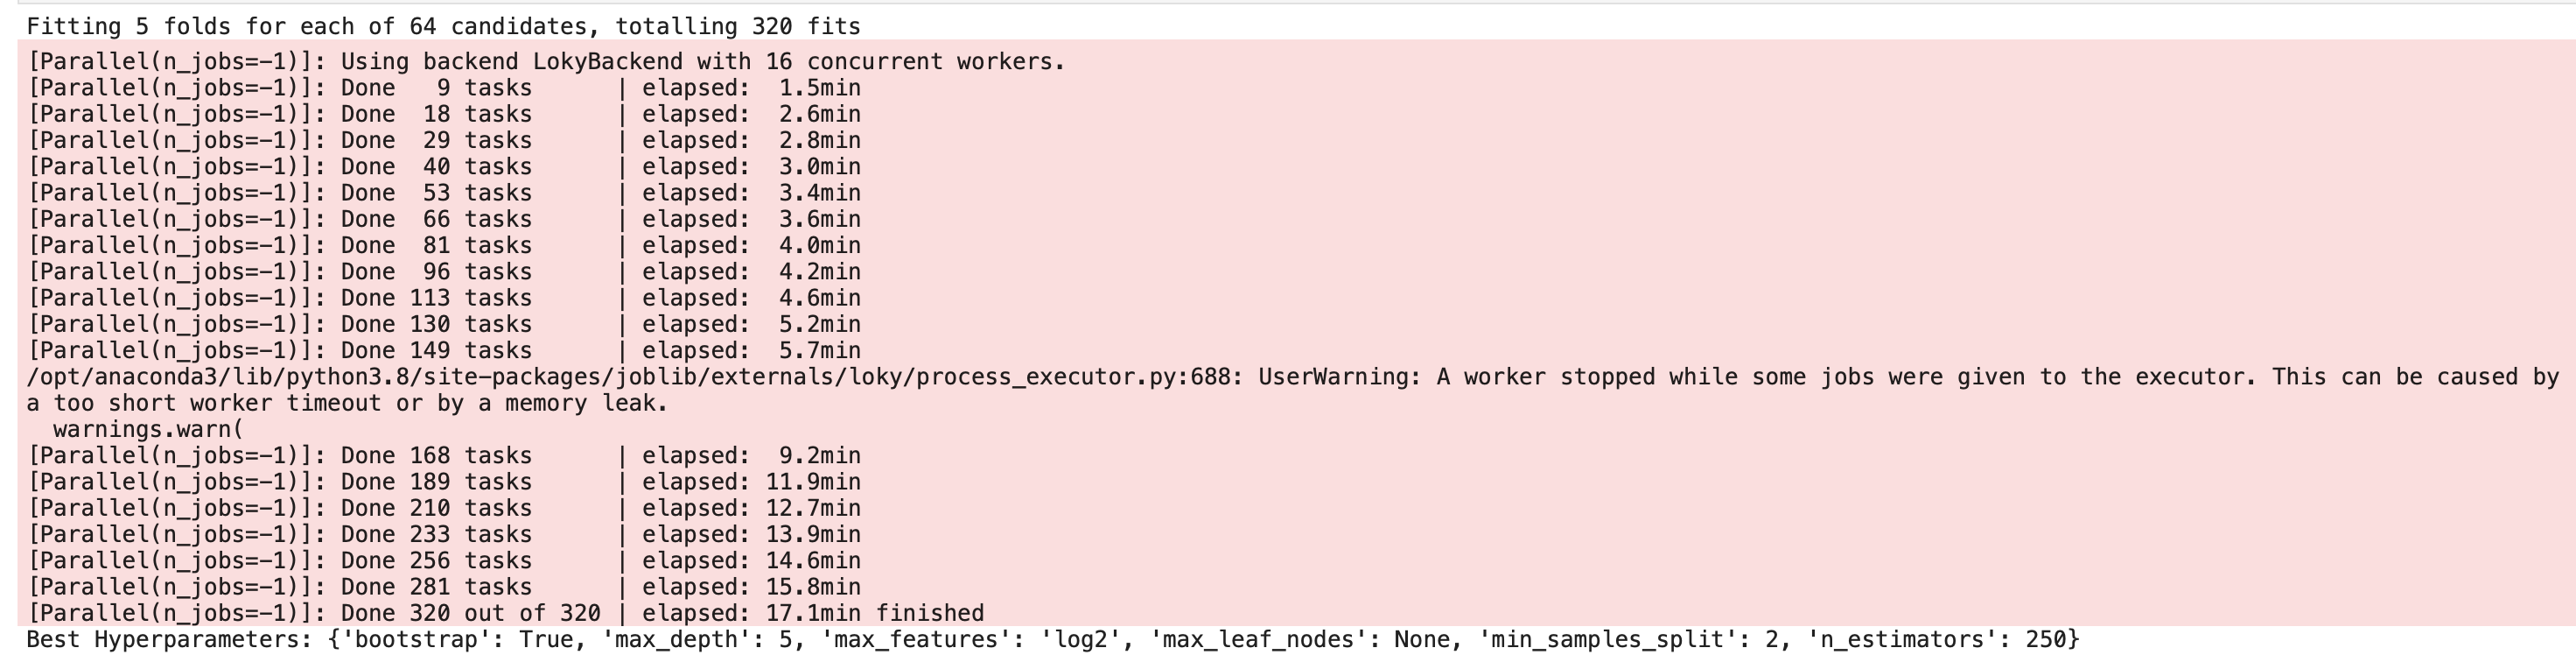

In [ ]:
y = train_data['retnm']
X = train_data[features]

best_hyperparameters = {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_split': 2, 'n_estimators': 250}

best_model = RandomForestRegressor(**best_hyperparameters, random_state=42)

# Fit the model to the data
best_model.fit(X, y);

# Interpreting the model

- Unlike with a linear regression, models such as random forests and neural networks are more "block box"-like
- We could either fit a simpler model to the fitted data OR we can measure variable importance / Shapley values to get a sense of what drives the model's predictions

In [ ]:
# retrieve variable importances from the best model
importances = best_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(14, 10))
sorted_idx = importances.argsort()
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

In [ ]:
train_data['pred_retnm'] = best_model.predict(X) 

training_returns = compute_strategy_returns(train_data)
analyze_returns(r=training_returns, name='Random forest regression predictions in the training sample')

In [ ]:
X_validation = validation_data[features]

# we can feed features from the validation sample to the estimated model using the "predict" method
validation_data['pred_retnm'] = best_model.predict(X_validation)

validation_returns = compute_strategy_returns(validation_data)
analyze_returns(r=validation_returns, name='Random forest regression predictions in the validation sample')